In [2]:
import torch
import os,sys
sys.path.append("..")

In [3]:
# --- Stage-0 : set paths & load raw arrays ----------------------------
from pathlib import Path
import numpy as np

DATA_DIR = Path(rf"/home/bardiya/projects/diffusion_air_manifolding/codes/creative-generativeai-diffusion/data/raw")          # change here if you move the .npy files

RAW_X_TRAIN = DATA_DIR / "xs_train.npy"
RAW_X_TEST  = DATA_DIR / "xs_test.npy"
RAW_Y_TRAIN = DATA_DIR / "ys_train.npy"
RAW_Y_TEST  = DATA_DIR / "ys_test.npy"

xs_train = np.load(RAW_X_TRAIN)           # (N_train, 192, 2)
xs_test  = np.load(RAW_X_TEST)            # (N_test , 192, 2)
ys_train = np.load(RAW_Y_TRAIN)           # (N_train, 2)  -> [CL, CD]
ys_test  = np.load(RAW_Y_TEST)            # (N_test , 2)

print("Train shapes :", xs_train.shape, ys_train.shape)
print("Test  shapes :", xs_test.shape , ys_test.shape)
# ----------------------------------------------------------------------


Train shapes : (38802, 192, 2) (38802, 2)
Test  shapes : (9701, 192, 2) (9701, 2)


# Hybrid model

In [4]:
import sys, os
sys.path.append(os.path.abspath(".."))
sys.path.append(os.path.abspath("../.."))
sys.path.append("../surrogate_models")
import torch.nn as nn
import torch.nn.functional as F
import torch

activation_function_list = [torch.tanh, nn.ReLU(), nn.CELU(), nn.LeakyReLU(), nn.ELU(), nn.Hardswish(),torch.tanh, nn.ReLU(), nn.CELU(), nn.LeakyReLU(), torch.tanh]

class MultiLayerPerceptron_forward(nn.Module):
    def __init__(self, input_size, hidden_layers, num_classes, net_n):
        super(MultiLayerPerceptron_forward, self).__init__()
        #################################################################################
        # Initialize the modules required to implement the mlp with given layer   #
        # configuration. input_size --> hidden_layers[0] --> hidden_layers[1] .... -->  #
        # hidden_layers[-1] --> num_classes                                             #
        #################################################################################
        layers = []
        layers.append(nn.Linear((input_size), (hidden_layers[0])))
        for i in range(len(hidden_layers)-1):
            layers.append(nn.Linear((hidden_layers[i]), (hidden_layers[i+1])))

        layers.append(nn.Linear((hidden_layers[len(hidden_layers)-1]), (num_classes)))
        self.layers = nn.Sequential(*layers)
        self.net_n = net_n
        self.hidden_layers = hidden_layers
    def forward(self, x):
        #################################################################################
        # Implement the forward pass computations                                 #
        #################################################################################
        m = activation_function_list[self.net_n]
        for i in range(len(self.hidden_layers)):
            x = self.layers[i](x)
            x = m(x)
        x = (self.layers[len(self.hidden_layers)](x))
        out=x
        return out

#====================================================

class Hybrid_surrogate_MLP(nn.Module):
    def __init__(self, 
                 input_size, 
                 hidden_layers_cl_model ,
                 hidden_layers_cd_model , 
                 net_n_cl=3 , 
                 net_n_cd=3, 
                 path_cl_model = None, 
                 path_cd_model  =  None):
        super(Hybrid_surrogate_MLP, self).__init__()
        self.cl_forward_mlp = MultiLayerPerceptron_forward(input_size , hidden_layers_cl_model ,   num_classes=1  , net_n=net_n_cl)
        self.cd_forward_mlp = MultiLayerPerceptron_forward(input_size , hidden_layers_cd_model ,   num_classes=1  , net_n=net_n_cd)
        if path_cl_model:
            self.cl_forward_mlp.load_state_dict(torch.load(path_cl_model,map_location="cpu"))
        if path_cd_model:
            self.cd_forward_mlp.load_state_dict(torch.load(path_cd_model,map_location="cpu"))

    def forward(self, x):
        #################################################################################
        # Implement the forward pass computations                                 #
        #################################################################################
        """
            x.shape= (batch , 192, 2)
        """
        x = x.reshape(x.shape[0],-1)
        cl = self.cl_forward_mlp(x)
        cd = self.cd_forward_mlp(x)
        return torch.stack([cl,cd],dim=1).squeeze(-1)
 



## results for DDPM unscaled without dpp loss

In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Make sure you have your SurrogateModel1D class and AirfoilDataset class defined from before
# e.g.:
# class SurrogateModel1D(nn.Module): ...
# class AirfoilDataset(Dataset): ...
# etc.

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Paths
checkpoint_dir = "/content/drive/MyDrive/AI/Airfoil_diffusion/surrogate_model/residualV1/best_model.pt"
# best_model_path = f"{checkpoint_dir}/best_model.pt"

# Reconstruct your best Residual model
residv1_best_model = Hybrid_surrogate_MLP(input_size=192 * 2, 
                                 hidden_layers_cd_model=[200,300,300,200],
                                 hidden_layers_cl_model=[150, 200,200,150],
                                 path_cd_model=rf"/home/bardiya/projects/diffusion_air_manifolding/codes/creative-generativeai-diffusion/src/surrogate_models/Surrogate_Model_weigths/just_for_cd_200_300_300_200/mlp_best_model.pt",
                                 path_cl_model=rf"/home/bardiya/projects/diffusion_air_manifolding/codes/creative-generativeai-diffusion/src/surrogate_models/Surrogate_Model_weigths/just_for_cl_150_200_200_150/mlp_best_model.pt"
                                 ).to(device)

# Load the checkpoint
# residv1_best_model.load_state_dict(torch.load(checkpoint_dir, map_location=device))
residv1_best_model.eval()
print("Loaded best Residual surrogate model.")


Loaded best Residual surrogate model.


/tmp/ipykernel_4589/298942254.py:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.cl_forward_mlp.load_state_dict(torch.load(path_cl_model,map_location="cpu"))
/tmp/ipy

In [7]:
def predict_airfoils_residual(model, airfoils_np, y_min, y_max, device='cpu', batch_size=128):
    """
    Predict (CL, CL/CD) in *real* scale for an array of airfoils, shape (N, 2, 192).
    Returns an array of shape (N, 2) => columns [CL_real, ratio_real].
    """
    model.eval()

    # We will store predictions here
    all_preds = []

    n_total = airfoils_np.shape[0]
    idx_start = 0

    while idx_start < n_total:
        idx_end = min(idx_start + batch_size, n_total)
        batch_np = airfoils_np[idx_start:idx_end]  # shape (batch, 2, 192)

        # Convert to torch
        batch_torch = torch.from_numpy(batch_np).float().to(device)  # (batch, 2, 192)

        with torch.no_grad():
            # Surrogate model forward => scaled predictions, shape (batch, 2)
            preds_scaled = model(batch_torch)  # in [0,1] space
            # Move to CPU for inverse scaling
            preds_scaled_cpu = preds_scaled.cpu().numpy()  # shape (batch,2)

        # Inverse scale
        eps = 1e-12
        real_label = preds_scaled_cpu * (y_max - y_min + eps) + y_min  # shape (batch,2)

        all_preds.append(real_label)
        idx_start = idx_end

    all_preds = np.concatenate(all_preds, axis=0)  # shape (N,2)
    return all_preds


In [13]:
# 3.1) Load the generated airfoils
generated_path = rf"/home/bardiya/projects/diffusion_air_manifolding/codes/creative-generativeai-diffusion/src/surrogate_models/Generated_samples/unscaled_ddpm/generated_airfoils_RMS_fixed_auto_norm_false.npy"
gen_airfoils = np.load(generated_path)  # shape: (N_generated, 2, 192)
print("Generated airfoils shape:", gen_airfoils.shape)

# === NEW: Load training data to get bounding box for x, y ===
xs_train_path = rf"/home/bardiya/projects/diffusion_air_manifolding/codes/creative-generativeai-diffusion/data/raw/xs_train.npy"
xs_train = np.load(xs_train_path)  # shape: (N_train, 192, 2)

train_xmin = xs_train[..., 0].min()
train_xmax = xs_train[..., 0].max()
train_ymin = xs_train[..., 1].min()
train_ymax = xs_train[..., 1].max()

# Compute the bounding box in the generated data
gen_xmin = gen_airfoils[:, 0, :].min()
gen_xmax = gen_airfoils[:, 0, :].max()
gen_ymin = gen_airfoils[:, 1, :].min()
gen_ymax = gen_airfoils[:, 1, :].max()

# Shift+scale the generated airfoils to match the train bounding box
gen_airfoils_shifted = gen_airfoils.copy()
eps = 1e-12

# -- X channel
gen_airfoils_shifted[:, 0, :] = (gen_airfoils_shifted[:, 0, :] - gen_xmin) / (gen_xmax - gen_xmin + eps)
gen_airfoils_shifted[:, 0, :] = gen_airfoils_shifted[:, 0, :] * (train_xmax - train_xmin) + train_xmin

# -- Y channel
gen_airfoils_shifted[:, 1, :] = (gen_airfoils_shifted[:, 1, :] - gen_ymin) / (gen_ymax - gen_ymin + eps)
gen_airfoils_shifted[:, 1, :] = gen_airfoils_shifted[:, 1, :] * (train_ymax - train_ymin) + train_ymin

gen_airfoils = gen_airfoils_shifted

# 3.2) Load the real test airfoils
real_xs_test_path = rf"/home/bardiya/projects/diffusion_air_manifolding/codes/creative-generativeai-diffusion/data/raw/xs_test.npy"  # shape: (N_test, 192, 2)
real_test = np.load(real_xs_test_path)
# We want to feed them in the shape (N, 2, 192), so transpose if needed
# real_test = np.transpose(real_test, (0,2,1))  # (N_test, 2, 192)
print("Real test airfoils shape (transposed):", real_test.shape)

# 3.3) Also load min_y, max_y for inverse-scaling
y_min = 0
y_max = 1


Generated airfoils shape: (9701, 192, 2)
Real test airfoils shape (transposed): (9701, 192, 2)


In [14]:
# 4.1) Predict for generated
gen_preds = predict_airfoils_residual(
    residv1_best_model,
    gen_airfoils,
    y_min,
    y_max,
    device=device,
    batch_size=128
)  # shape (N_generated, 2) => [CL, CL/CD]

# 4.2) Predict for real test
test_preds = predict_airfoils_residual(
    residv1_best_model,
    real_test,
    y_min,
    y_max,
    device=device,
    batch_size=128
)  # shape (N_test, 2) => [CL, CL/CD]


In [15]:
gen_preds[0] , test_preds[0]

(array([0.26814035, 0.00793036], dtype=float32),
 array([0.19971702, 0.00408414], dtype=float32))

In [19]:
def convert_CL_CD_to_ratio(pred_array):
    """
    pred_array shape: (N, 2) => columns [CL, (CL/CD)] in real scale
    returns an array shape (N,3) => columns [CL, ratio, CD]
    """
    eps = 1e-12
    CL = pred_array[:, 0]
    CD = pred_array[:, 1]
    ratio = CL / (CD + eps)
    return np.column_stack([CL, ratio, CD])

gen_perf = convert_CL_CD_to_ratio(gen_preds)   # shape: (N_generated, 3)
test_perf = convert_CL_CD_to_ratio(test_preds) # shape: (N_test, 3)

# For convenience:
# gen_perf[:,0] = CL
# gen_perf[:,1] = CL/CD ratio
# gen_perf[:,2] = CD


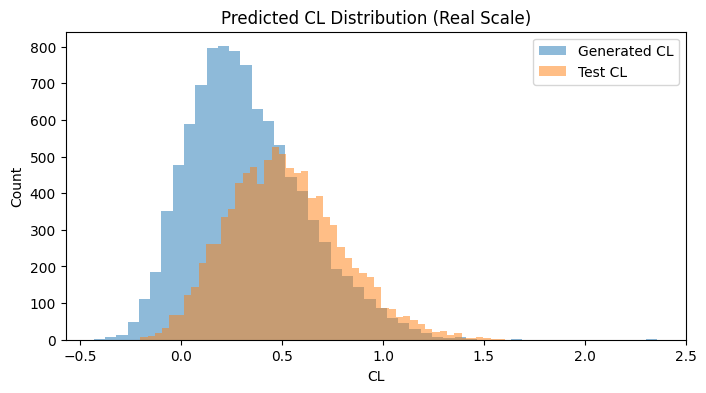

In [20]:
plt.figure(figsize=(8,4))
plt.hist(gen_perf[:,0], bins=50, alpha=0.5, label="Generated CL")
plt.hist(test_perf[:,0], bins=50, alpha=0.5, label="Test CL")
plt.title("Predicted CL Distribution (Real Scale)")
plt.xlabel("CL")
plt.ylabel("Count")
plt.legend()
plt.show()


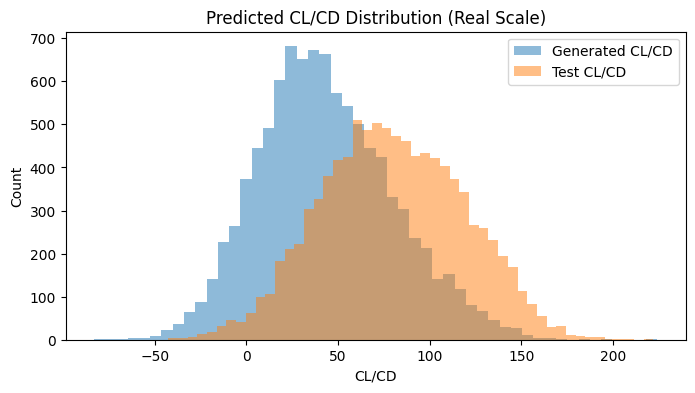

In [21]:
plt.figure(figsize=(8,4))
plt.hist(gen_perf[:,1], bins=50, alpha=0.5, label="Generated CL/CD")
plt.hist(test_perf[:,1], bins=50, alpha=0.5, label="Test CL/CD")
plt.title("Predicted CL/CD Distribution (Real Scale)")
plt.xlabel("CL/CD")
plt.ylabel("Count")
plt.legend()
plt.show()


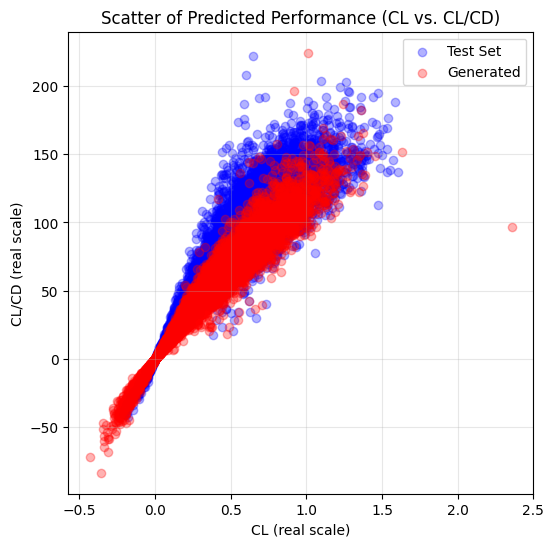

In [24]:
plt.figure(figsize=(6,6))
# real_labels = np.load("/content/data/ys_test_scaled.npy")
# plt.scatter(real_labels[:,0], real_labels[:,0] / real_labels[:,1], c='blue', alpha=0.3, label='Test Set')
# plt.scatter(test_preds[:,0], test_preds[:,1], c='blue', alpha=0.3, label='Test Set')
# plt.scatter(gen_preds[:,0],  gen_preds[:,1],  c='red',  alpha=0.3, label='Generated')
plt.scatter(test_perf[:,0], test_perf[:,1], c='blue', alpha=0.3, label='Test Set')
plt.scatter(gen_perf[:,0],  gen_perf[:,1],  c='red',  alpha=0.3, label='Generated')
# plt.scatter(real_labels[:,0], real_labels[:,0] / real_labels[:,1],  c='red',  alpha=0.3, label='Generated')
plt.title("Scatter of Predicted Performance (CL vs. CL/CD)")
plt.xlabel("CL (real scale)")
plt.ylabel("CL/CD (real scale)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


## results for DDPMwith dpp loss 0.1

In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Make sure you have your SurrogateModel1D class and AirfoilDataset class defined from before
# e.g.:
# class SurrogateModel1D(nn.Module): ...
# class AirfoilDataset(Dataset): ...
# etc.

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Paths
checkpoint_dir = "/content/drive/MyDrive/AI/Airfoil_diffusion/surrogate_model/residualV1/best_model.pt"
# best_model_path = f"{checkpoint_dir}/best_model.pt"

# Reconstruct your best Residual model
residv1_best_model = Hybrid_surrogate_MLP(input_size=192 * 2, 
                                 hidden_layers_cd_model=[200,300,300,200],
                                 hidden_layers_cl_model=[150, 200,200,150],
                                 path_cd_model=rf"/home/bardiya/projects/diffusion_air_manifolding/codes/creative-generativeai-diffusion/src/surrogate_models/Surrogate_Model_weigths/just_for_cd_200_300_300_200/mlp_best_model.pt",
                                 path_cl_model=rf"/home/bardiya/projects/diffusion_air_manifolding/codes/creative-generativeai-diffusion/src/surrogate_models/Surrogate_Model_weigths/just_for_cl_150_200_200_150/mlp_best_model.pt"
                                 ).to(device)

# Load the checkpoint
# residv1_best_model.load_state_dict(torch.load(checkpoint_dir, map_location=device))
residv1_best_model.eval()
print("Loaded best Residual surrogate model.")


Loaded best Residual surrogate model.


/tmp/ipykernel_3886/298942254.py:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.cl_forward_mlp.load_state_dict(torch.load(path_cl_model,map_location="cpu"))
/tmp/ipy

In [6]:
def predict_airfoils_residual(model, airfoils_np, y_min, y_max, device='cpu', batch_size=128):
    """
    Predict (CL, CL/CD) in *real* scale for an array of airfoils, shape (N, 2, 192).
    Returns an array of shape (N, 2) => columns [CL_real, ratio_real].
    """
    model.eval()

    # We will store predictions here
    all_preds = []

    n_total = airfoils_np.shape[0]
    idx_start = 0

    while idx_start < n_total:
        idx_end = min(idx_start + batch_size, n_total)
        batch_np = airfoils_np[idx_start:idx_end]  # shape (batch, 2, 192)

        # Convert to torch
        batch_torch = torch.from_numpy(batch_np).float().to(device)  # (batch, 2, 192)

        with torch.no_grad():
            # Surrogate model forward => scaled predictions, shape (batch, 2)
            preds_scaled = model(batch_torch)  # in [0,1] space
            # Move to CPU for inverse scaling
            preds_scaled_cpu = preds_scaled.cpu().numpy()  # shape (batch,2)

        # Inverse scale
        eps = 1e-12
        real_label = preds_scaled_cpu * (y_max - y_min + eps) + y_min  # shape (batch,2)

        all_preds.append(real_label)
        idx_start = idx_end

    all_preds = np.concatenate(all_preds, axis=0)  # shape (N,2)
    return all_preds


In [ ]:
# 3.1) Load the generated airfoils
generated_path = rf"/home/bardiya/projects/diffusion_air_manifolding/codes/creative-generativeai-diffusion/src/diffusion_notebooks/DIffusion_model_weigths_and_datas/dpp_0.1_autonorm_true_125_from_base_ddpm/datas/generated_data_dpp_0.1_autonorm_false_rmsnorm_fixed.npy"
gen_airfoils = np.load(generated_path)  # shape: (N_generated, 2, 192)
print("Generated airfoils shape:", gen_airfoils.shape)

# === NEW: Load training data to get bounding box for x, y ===
xs_train_path = rf"/home/bardiya/projects/diffusion_air_manifolding/codes/creative-generativeai-diffusion/data/raw/xs_train.npy"
xs_train = np.load(xs_train_path)  # shape: (N_train, 192, 2)

train_xmin = xs_train[..., 0].min()
train_xmax = xs_train[..., 0].max()
train_ymin = xs_train[..., 1].min()
train_ymax = xs_train[..., 1].max()

# Compute the bounding box in the generated data
gen_xmin = gen_airfoils[:, 0, :].min()
gen_xmax = gen_airfoils[:, 0, :].max()
gen_ymin = gen_airfoils[:, 1, :].min()
gen_ymax = gen_airfoils[:, 1, :].max()

# Shift+scale the generated airfoils to match the train bounding box
gen_airfoils_shifted = gen_airfoils.copy()
eps = 1e-12

# -- X channel
gen_airfoils_shifted[:, 0, :] = (gen_airfoils_shifted[:, 0, :] - gen_xmin) / (gen_xmax - gen_xmin + eps)
gen_airfoils_shifted[:, 0, :] = gen_airfoils_shifted[:, 0, :] * (train_xmax - train_xmin) + train_xmin

# -- Y channel
gen_airfoils_shifted[:, 1, :] = (gen_airfoils_shifted[:, 1, :] - gen_ymin) / (gen_ymax - gen_ymin + eps)
gen_airfoils_shifted[:, 1, :] = gen_airfoils_shifted[:, 1, :] * (train_ymax - train_ymin) + train_ymin

gen_airfoils = gen_airfoils_shifted

# 3.2) Load the real test airfoils
real_xs_test_path = rf"/home/bardiya/projects/diffusion_air_manifolding/codes/creative-generativeai-diffusion/data/raw/xs_test.npy"  # shape: (N_test, 192, 2)
real_test = np.load(real_xs_test_path)
# We want to feed them in the shape (N, 2, 192), so transpose if needed
# real_test = np.transpose(real_test, (0,2,1))  # (N_test, 2, 192)
print("Real test airfoils shape (transposed):", real_test.shape)

# 3.3) Also load min_y, max_y for inverse-scaling
y_min = 0
y_max = 1


Generated airfoils shape: (9701, 192, 2)
Real test airfoils shape (transposed): (9701, 192, 2)


In [8]:
# 4.1) Predict for generated
gen_preds = predict_airfoils_residual(
    residv1_best_model,
    gen_airfoils,
    y_min,
    y_max,
    device=device,
    batch_size=128
)  # shape (N_generated, 2) => [CL, CL/CD]

# 4.2) Predict for real test
test_preds = predict_airfoils_residual(
    residv1_best_model,
    real_test,
    y_min,
    y_max,
    device=device,
    batch_size=128
)  # shape (N_test, 2) => [CL, CL/CD]


In [9]:
gen_preds[0] , test_preds[0]

(array([1.3542116 , 0.00636404], dtype=float32),
 array([0.19971702, 0.00408414], dtype=float32))

In [10]:
def convert_CL_CD_to_ratio(pred_array):
    """
    pred_array shape: (N, 2) => columns [CL, (CL/CD)] in real scale
    returns an array shape (N,3) => columns [CL, ratio, CD]
    """
    eps = 1e-12
    CL = pred_array[:, 0]
    CD = pred_array[:, 1]
    ratio = CL / (CD + eps)
    return np.column_stack([CL, ratio, CD])

gen_perf = convert_CL_CD_to_ratio(gen_preds)   # shape: (N_generated, 3)
test_perf = convert_CL_CD_to_ratio(test_preds) # shape: (N_test, 3)

# For convenience:
# gen_perf[:,0] = CL
# gen_perf[:,1] = CL/CD ratio
# gen_perf[:,2] = CD


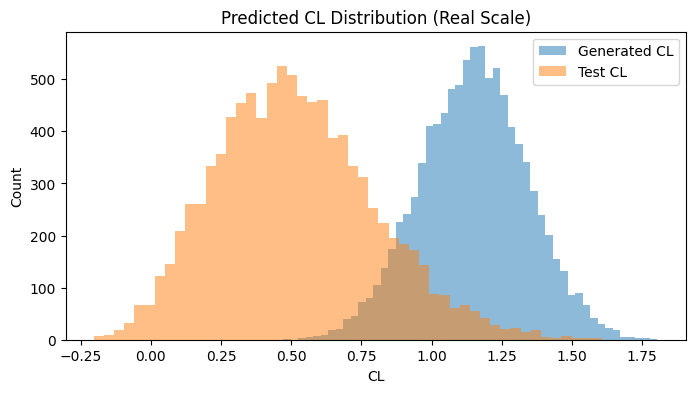

In [11]:
plt.figure(figsize=(8,4))
plt.hist(gen_perf[:,0], bins=50, alpha=0.5, label="Generated CL")
plt.hist(test_perf[:,0], bins=50, alpha=0.5, label="Test CL")
plt.title("Predicted CL Distribution (Real Scale)")
plt.xlabel("CL")
plt.ylabel("Count")
plt.legend()
plt.show()


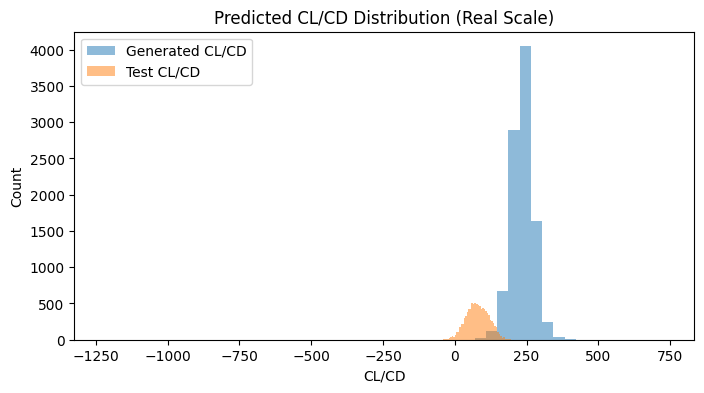

In [12]:
plt.figure(figsize=(8,4))
plt.hist(gen_perf[:,1], bins=50, alpha=0.5, label="Generated CL/CD")
plt.hist(test_perf[:,1], bins=50, alpha=0.5, label="Test CL/CD")
plt.title("Predicted CL/CD Distribution (Real Scale)")
plt.xlabel("CL/CD")
plt.ylabel("Count")
plt.legend()
plt.show()


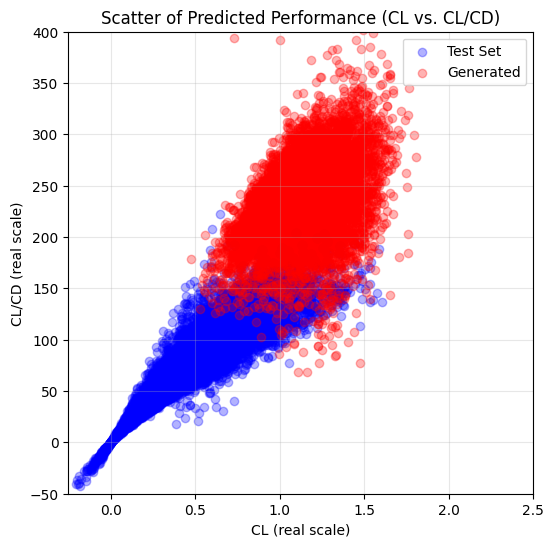

In [20]:
plt.figure(figsize=(6,6))
# real_labels = np.load("/content/data/ys_test_scaled.npy")
# plt.scatter(real_labels[:,0], real_labels[:,0] / real_labels[:,1], c='blue', alpha=0.3, label='Test Set')
# plt.scatter(test_preds[:,0], test_preds[:,1], c='blue', alpha=0.3, label='Test Set')
# plt.scatter(gen_preds[:,0],  gen_preds[:,1],  c='red',  alpha=0.3, label='Generated')
plt.scatter(test_perf[:,0], test_perf[:,1], c='blue', alpha=0.3, label='Test Set')
plt.scatter(gen_perf[:,0],  gen_perf[:,1],  c='red',  alpha=0.3, label='Generated')
# plt.scatter(real_labels[:,0], real_labels[:,0] / real_labels[:,1],  c='red',  alpha=0.3, label='Generated')
plt.title("Scatter of Predicted Performance (CL vs. CL/CD)")
plt.xlabel("CL (real scale)")
plt.ylabel("CL/CD (real scale)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(-0.25,2.5)
plt.ylim(-50,400)
plt.show()
